**линейная регрессия, метод градиентного спуска**

Евгений Борисов  <esborisov@sevsu.ru>

In [1]:
import numpy as np
from numpy import random as rng
import matplotlib.pyplot as plt

In [2]:
np.set_printoptions(precision=2)

## генерируем данные

In [3]:
n_samples=500
X = np.linspace(-1,1,n_samples).reshape(-1,1)
target = np.sin((X)*2.9)+np.random.rand(n_samples).reshape(-1,1)

y = target # [:,np.newaxis]

X.shape,y.shape

((500, 1), (500, 1))

In [4]:
# нормируем данные
# from sklearn.preprocessing import MinMaxScaler
# X = MinMaxScaler([-1.0,1.0]).fit_transform(X)

# from sklearn.preprocessing   import StandardScaler
# X = StandardScaler().fit(X).transform(X)

In [5]:
# np.percentile(X,[10,25,50,75,95],axis=0) 

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.5)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((250, 1), (250, 1), (250, 1), (250, 1))

In [7]:
del X
del y
del target

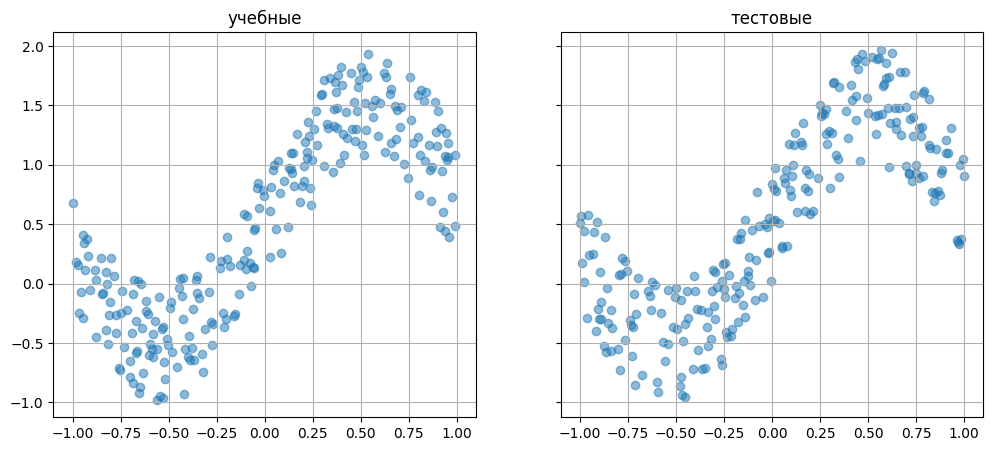

In [8]:
def plot_data(ax,X,y,t):
    ax.set_title(t)
    ax.scatter( x=X, y=y,alpha=0.5 )
    ax.grid()

fig, (ax0,ax1) = plt.subplots(1,2, sharey=True, sharex=True, figsize=(12,5),)
plot_data(ax0,X_train,y_train,'учебные')    
plot_data(ax1,X_test,y_test,'тестовые')    
plt.show()

In [9]:
from sklearn.preprocessing import PolynomialFeatures

poly_degree = 3 # степень полинома

# собираем полином, добавляем столбец из единиц (свободный член)
poly = PolynomialFeatures(poly_degree).fit(X_train)
Xp = poly.transform(X_train)
Xp.shape

(250, 4)

## модель

$$a(x,w) = \sum\limits_{i=1} x_i \cdot w_i + w_0$$

In [10]:
def model(x,w): # модель логрегересии
    return x.dot(w)[:,np.newaxis]

In [11]:
def model_partial(x,w): # частные производные модели по её параметрам
    return x

## обучаем модель

функция потери средняя квадратичная ошибка
$$L=MSQE(y,o)=\frac{1}{m}\sum\limits_{i=0}^m(o_i-y_i)^2$$

In [12]:
def msqe(y,o): # средняя квадратичная ошибка
    d = o-y 
    return d.T.dot(d).flatten()[0]/len(y)

loss = msqe

частные производные функции потери по параметрам модели (градиент)

$$ \frac{\partial L }{\partial w} = 2 \cdot( o - y ) \cdot \frac{\partial o }{\partial w}  $$

In [13]:
def msqe_partial(x,w,y): # градиент функции потери,
    g = model_partial(x,w).T.dot(model(x,w)-y) # градиент msqe
    g /= np.abs(g).max() # нормируем градиент
    return g.flatten()

gradient = msqe_partial

---

In [14]:
def weight_adjust(w,g,lr):
    return w - lr*g # корректируем параметры

In [15]:
def fit_epoch(x,y,w,lr): # шаг обучения модели
    g = gradient(x,w,y) # градиент функции потери, изменение весов
    return weight_adjust(w,g,lr) # корректируем параметры

In [16]:
from sklearn.metrics import accuracy_score

In [17]:
%%time

# метод градиентного спуска

lr = 1e-2 # скорость обучени
n_samples = len(y_train) # количество примеров
n_epoch = 500 # максимальное число циклов обучения
n_param = Xp.shape[1] # размер вектора признаков

# инициализация параметров модели
w = rng.normal(size=(n_param))
#w = np.array( [0] + [1]*(n_param-1) )

# начальное значение ф-ции потери
loss_history = [ loss(y_train,model(Xp,w)) ]

for i in range(n_epoch): # цикл обучения
    w = fit_epoch(Xp,y_train,w,lr) # корректируем веса модели
    loss_history.append( loss(y_train,model(Xp,w)) ) # считаем значение ф-ции потери

CPU times: user 34.4 ms, sys: 332 µs, total: 34.7 ms
Wall time: 34.4 ms


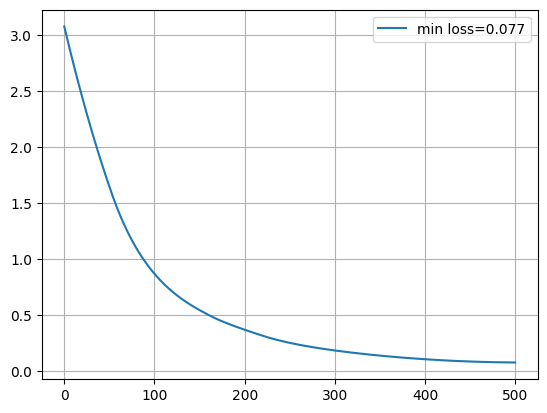

In [18]:
# история изменения значений ф-ции потери
plt.plot(loss_history,label='min loss=%.3f'%(min(loss_history)))
plt.grid()
plt.legend()

## тестируем модель

In [19]:
x_train = np.linspace(X_train.min(axis=0)[0],X_train.max(axis=0)[0],len(y_train))[:,np.newaxis]
s_train = model(poly.transform(x_train),w)
msqe_train = msqe(y_train,s_train)

x_test = np.linspace(X_test.min(axis=0)[0],X_test.max(axis=0)[0],len(y_test))[:,np.newaxis]
s_test = model(poly.transform(x_test),w)
msqe_test = msqe(y_test,s_test)

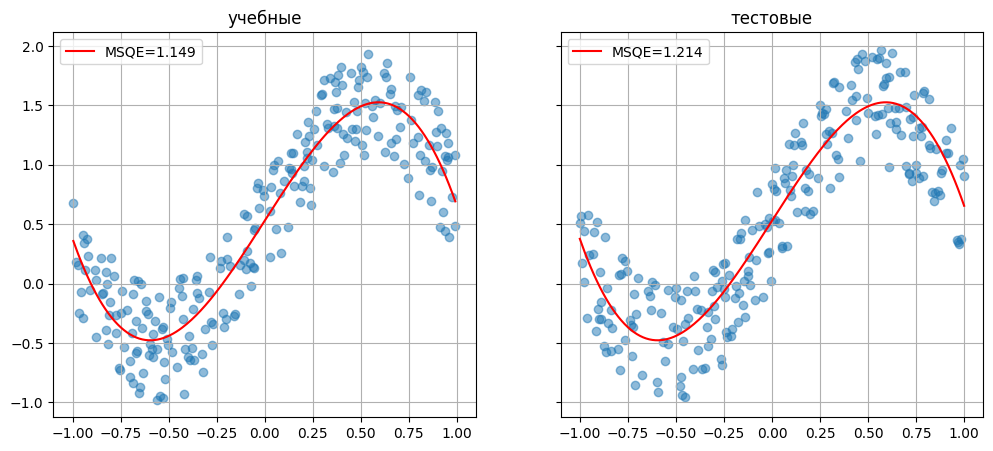

In [20]:
fig, (ax0,ax1) = plt.subplots(1,2, sharey=True, sharex=True, figsize=(12,5),)
plot_data(ax0,X_train,y_train,'учебные')  
ax0.plot(x_train,s_train,c='r',label='MSQE=%.3f'%(msqe_train))
ax0.legend()

plot_data(ax1,X_test,y_test,'тестовые')    
ax1.plot(x_test,s_test,c='r',label='MSQE=%.3f'%(msqe_test))
ax1.legend()

plt.show()